In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet34_Weights
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation, rkd_test_model
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison


# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.001
epochs = 300
epochs_pretrain = 3
epochs_optimal_lr = 3
patience_teacher = 10  # 6
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
# batch_size = 128
batch_size = 384

num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = True

# list of lambda values to loop through for grid search
lmda_list = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = 'data/WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'data/WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'data/WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "data/WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider') #, include_augmented=include_augmented)
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)

testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


# Start Training Process

In [11]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [12]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models


teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.fc = nn.Linear(512, num_classes)

student_model = CustomResNet18()
student_model.fc = nn.Linear(512, num_classes)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [13]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [14]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [15]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_adversary(adv, model, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        model = model.to(device)
        adversary_optimizer.zero_grad()
        student_output = model(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [17]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [18]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [19]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [20]:
# # for testing, delete this cell
# best_lr_teacher = learning_rate
# best_lr_student = learning_rate

best_lr_teacher = 0.003934318606406605
best_lr_student = 0.006674426826180685

In [21]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [22]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [23]:
# Function to train the teacher model
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:09<00:00,  4.18s/it]


*******Epoch 0: loss - 2.8391029680928876


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:11<00:00,  4.25s/it]


*******Epoch 1: loss - 2.554234581608926


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:11<00:00,  4.25s/it]


*******Epoch 2: loss - 2.479052443658152


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:05<00:00,  4.05s/it]


Average Pretrain Adversary epoch loss:  0.3419953575057368


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:04<00:00,  4.01s/it]


Average Pretrain Adversary epoch loss:  0.34247224753902805


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:04<00:00,  4.01s/it]


Average Pretrain Adversary epoch loss:  0.3417944244800075


100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 1/300*****
*****Train Loss:  2.413507 Val Loss:  2.410408*****
*****Validation Accuracy: 24.09%*****
*****Total Avg Disparity: 0.0788982939130464*****

Class Team_Sports: Recall Difference = -0.02922425426962627
Class Celebration: Recall Difference = 0.007765151515151517
Class Parade: Recall Difference = -0.0625
Class Waiter_Or_Waitress: Recall Difference = 0.21333333333333337
Class Individual_Sports: Recall Difference = -0.1470051687442992
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.013698630136986304
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water_Activities: Recall Difference = 0.1186813186813187
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.03897849462365591
Class Family: Recall Difference = 0.0


100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


*****Epoch 2/300*****
*****Train Loss:  2.368456 Val Loss:  2.309304*****
*****Validation Accuracy: 26.28%*****
*****Total Avg Disparity: 0.032066282141888856*****

Class Team_Sports: Recall Difference = -0.03392433337986889
Class Celebration: Recall Difference = 0.012689393939393931
Class Parade: Recall Difference = -0.009469696969696961
Class Waiter_Or_Waitress: Recall Difference = -0.08
Class Individual_Sports: Recall Difference = 0.006840985101854685
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.029843444227005855
Class Business: Recall Difference = 0.005627705627705624
Class Dresses: Recall Difference = -0.006172839506172811
Class Water_Activities: Recall Difference = 0.026373626373626335
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.03773584905660378
Class Performance_And_Entertainment: Recall Difference = -0.05040322580645164
Class Family:

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 3/300*****
*****Train Loss:  2.328586 Val Loss:  2.417319*****
*****Validation Accuracy: 22.48%*****
*****Total Avg Disparity: 0.05880519651823477*****

Class Team_Sports: Recall Difference = -0.06733677695565166
Class Celebration: Recall Difference = -0.023484848484848487
Class Parade: Recall Difference = 0.02651515151515149
Class Waiter_Or_Waitress: Recall Difference = -0.1
Class Individual_Sports: Recall Difference = 0.01702645180906051
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.04696673189823877
Class Business: Recall Difference = 0.07142857142857142
Class Dresses: Recall Difference = 0.1419753086419753
Class Water_Activities: Recall Difference = 0.05934065934065935
Class Picnic: Recall Difference = -0.08695652173913043
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.05510752688172044
Class Family: Recall 

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 4/300*****
*****Train Loss:  2.281300 Val Loss:  2.320005*****
*****Validation Accuracy: 25.76%*****
*****Total Avg Disparity: 0.12124848260306823*****

Class Team_Sports: Recall Difference = 0.02266275768998094
Class Celebration: Recall Difference = 0.007575757575757569
Class Parade: Recall Difference = -0.13068181818181815
Class Waiter_Or_Waitress: Recall Difference = -0.19666666666666663
Class Individual_Sports: Recall Difference = -0.013529948312556939
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.01027397260273974
Class Business: Recall Difference = 0.023809523809523815
Class Dresses: Recall Difference = 0.030864197530864168
Class Water_Activities: Recall Difference = 0.08571428571428569
Class Picnic: Recall Difference = 0.09937888198757763
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.021739130434782608
Class Performance_And_Entertainment: Recall Difference = 0.0
C

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 5/300*****
*****Train Loss:  2.246456 Val Loss:  2.244471*****
*****Validation Accuracy: 27.78%*****
*****Total Avg Disparity: 0.08673542464378678*****

Class Team_Sports: Recall Difference = -0.001489133975522361
Class Celebration: Recall Difference = -0.07821969696969697
Class Parade: Recall Difference = -0.05492424242424243
Class Waiter_Or_Waitress: Recall Difference = -0.19666666666666666
Class Individual_Sports: Recall Difference = -0.15475828519306775
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16
Class Law_Enforcement: Recall Difference = 0.10029354207436397
Class Business: Recall Difference = -0.01255411255411256
Class Dresses: Recall Difference = -0.20370370370370375
Class Water_Activities: Recall Difference = 0.09010989010989012
Class Picnic: Recall Difference = -0.07453416149068323
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.02173913043478261
Class Performance_And_Entertainment: Recall Difference = 0.0

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


*****Epoch 6/300*****
*****Train Loss:  2.220496 Val Loss:  2.229476*****
*****Validation Accuracy: 30.66%*****
*****Total Avg Disparity: 0.08052699749122351*****

Class Team_Sports: Recall Difference = 0.03792638093908507
Class Celebration: Recall Difference = -0.03920454545454546
Class Parade: Recall Difference = -0.10037878787878796
Class Waiter_Or_Waitress: Recall Difference = -0.19666666666666663
Class Individual_Sports: Recall Difference = -0.08650045606567347
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.16
Class Law_Enforcement: Recall Difference = 0.03131115459882583
Class Business: Recall Difference = -0.17056277056277055
Class Dresses: Recall Difference = 0.018518518518518545
Class Water_Activities: Recall Difference = 0.09670329670329669
Class Picnic: Recall Difference = 0.012422360248447256
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.016129032258064516


100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 7/300*****
*****Train Loss:  2.198964 Val Loss:  2.192185*****
*****Validation Accuracy: 30.78%*****
*****Total Avg Disparity: 0.09983332493210219*****

Class Team_Sports: Recall Difference = -0.03992740471869338
Class Celebration: Recall Difference = -0.04185606060606059
Class Parade: Recall Difference = -0.026515151515151436
Class Waiter_Or_Waitress: Recall Difference = -0.09666666666666665
Class Individual_Sports: Recall Difference = -0.10276679841897246
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = -0.012720156555772966
Class Business: Recall Difference = -0.14112554112554113
Class Dresses: Recall Difference = -0.08641975308641975
Class Water_Activities: Recall Difference = 0.14065934065934066
Class Picnic: Recall Difference = 0.05590062111801243
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.00470430107526881

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 8/300*****
*****Train Loss:  2.153351 Val Loss:  2.352193*****
*****Validation Accuracy: 29.39%*****
*****Total Avg Disparity: 0.05874396979440754*****

Class Team_Sports: Recall Difference = -0.0363907115268276
Class Celebration: Recall Difference = -0.07329545454545455
Class Parade: Recall Difference = 0.013257575757575635
Class Waiter_Or_Waitress: Recall Difference = -0.15666666666666668
Class Individual_Sports: Recall Difference = -0.07798723016114317
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.09589041095890409
Class Business: Recall Difference = -0.018181818181818184
Class Dresses: Recall Difference = -0.17901234567901234
Class Water_Activities: Recall Difference = -0.013186813186813223
Class Picnic: Recall Difference = 0.0124223602484472
Class Rescue: Recall Difference = 0.010000000000000002
Class Cheering: Recall Difference = -0.04347826086956522
Class Performance_And_Entertainment: Recall Di

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 9/300*****
*****Train Loss:  2.122315 Val Loss:  2.158688*****
*****Validation Accuracy: 31.93%*****
*****Total Avg Disparity: 0.07982437376488595*****

Class Team_Sports: Recall Difference = -0.0012564567918470493
Class Celebration: Recall Difference = -0.039393939393939426
Class Parade: Recall Difference = 0.07007575757575757
Class Waiter_Or_Waitress: Recall Difference = -0.13666666666666671
Class Individual_Sports: Recall Difference = -0.1991486774095469
Class Surgeons: Recall Difference = -0.00882352941176471
Class Spa: Recall Difference = -0.08
Class Law_Enforcement: Recall Difference = 0.16144814090019569
Class Business: Recall Difference = -0.12294372294372294
Class Dresses: Recall Difference = -0.08024691358024691
Class Water_Activities: Recall Difference = 0.08791208791208793
Class Picnic: Recall Difference = 0.1118012422360248
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.002871205906480722
Class Performance_And_Entertainment: Recall 

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


*****Epoch 10/300*****
*****Train Loss:  2.100395 Val Loss:  2.241641*****
*****Validation Accuracy: 28.01%*****
*****Total Avg Disparity: 0.14557368293350129*****

Class Team_Sports: Recall Difference = 0.052864256131043785
Class Celebration: Recall Difference = -0.02102272727272725
Class Parade: Recall Difference = -0.09280303030303039
Class Waiter_Or_Waitress: Recall Difference = 0.053333333333333344
Class Individual_Sports: Recall Difference = -0.1152325934934631
Class Surgeons: Recall Difference = -0.044117647058823484
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.15557729941291581
Class Business: Recall Difference = 0.08701298701298701
Class Dresses: Recall Difference = -0.4012345679012347
Class Water_Activities: Recall Difference = 0.13186813186813184
Class Picnic: Recall Difference = -0.07453416149068323
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
C

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 11/300*****
*****Train Loss:  2.083776 Val Loss:  2.050118*****
*****Validation Accuracy: 34.81%*****
*****Total Avg Disparity: 0.0845253000384159*****

Class Team_Sports: Recall Difference = 0.05477220903718194
Class Celebration: Recall Difference = -0.13579545454545458
Class Parade: Recall Difference = -0.04734848484848475
Class Waiter_Or_Waitress: Recall Difference = -0.03666666666666667
Class Individual_Sports: Recall Difference = -0.13073882639100037
Class Surgeons: Recall Difference = -0.026470588235294107
Class Spa: Recall Difference = -0.04
Class Law_Enforcement: Recall Difference = 0.06800391389432486
Class Business: Recall Difference = -0.11168831168831167
Class Dresses: Recall Difference = -0.2777777777777777
Class Water_Activities: Recall Difference = 0.10109890109890107
Class Picnic: Recall Difference = 0.0124223602484472
Class Rescue: Recall Difference = 0.025
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.04

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 12/300*****
*****Train Loss:  2.039102 Val Loss:  2.113349*****
*****Validation Accuracy: 33.37%*****
*****Total Avg Disparity: 0.09687340797956222*****

Class Team_Sports: Recall Difference = 0.020940946530783155
Class Celebration: Recall Difference = -0.060416666666666674
Class Parade: Recall Difference = 0.06060606060606066
Class Waiter_Or_Waitress: Recall Difference = -0.15666666666666665
Class Individual_Sports: Recall Difference = -0.08422012769838849
Class Surgeons: Recall Difference = 0.09117647058823529
Class Spa: Recall Difference = -0.2
Class Law_Enforcement: Recall Difference = 0.3067514677103718
Class Business: Recall Difference = -0.08095238095238097
Class Dresses: Recall Difference = -0.12345679012345677
Class Water_Activities: Recall Difference = -0.019780219780219765
Class Picnic: Recall Difference = -0.031055900621118043
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.053732567678424936
Class Performance_And_Entertainment: Recall

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 13/300*****
*****Train Loss:  2.014832 Val Loss:  2.142711*****
*****Validation Accuracy: 30.72%*****
*****Total Avg Disparity: 0.1187706372003072*****

Class Team_Sports: Recall Difference = 0.19335473963423133
Class Celebration: Recall Difference = 0.04640151515151514
Class Parade: Recall Difference = 0.003787878787878729
Class Waiter_Or_Waitress: Recall Difference = -0.21666666666666667
Class Individual_Sports: Recall Difference = 0.013833992094861608
Class Surgeons: Recall Difference = 0.05
Class Spa: Recall Difference = -0.16
Class Law_Enforcement: Recall Difference = 0.19667318982387477
Class Business: Recall Difference = 0.033766233766233764
Class Dresses: Recall Difference = -0.33333333333333337
Class Water_Activities: Recall Difference = 0.10109890109890107
Class Picnic: Recall Difference = 0.006211180124223614
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.040994623655914
Cla

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


*****Epoch 14/300*****
*****Train Loss:  2.007445 Val Loss:  1.993185*****
*****Validation Accuracy: 38.16%*****
*****Total Avg Disparity: 0.1178080330626106*****

Class Team_Sports: Recall Difference = 0.05737819349434581
Class Celebration: Recall Difference = -0.08636363636363636
Class Parade: Recall Difference = 0.0018939393939393923
Class Waiter_Or_Waitress: Recall Difference = -0.10333333333333322
Class Individual_Sports: Recall Difference = -0.13241106719367585
Class Surgeons: Recall Difference = -0.017647058823529405
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.16634050880626222
Class Business: Recall Difference = -0.154978354978355
Class Dresses: Recall Difference = -0.4197530864197531
Class Water_Activities: Recall Difference = 0.10989010989010989
Class Picnic: Recall Difference = 0.06832298136645965
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.0028712059064807255
Class Performance_And_Entertai

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 15/300*****
*****Train Loss:  1.970628 Val Loss:  2.051366*****
*****Validation Accuracy: 36.37%*****
*****Total Avg Disparity: 0.10452201604787421*****

Class Team_Sports: Recall Difference = -0.002978267951044722
Class Celebration: Recall Difference = 0.015151515151515166
Class Parade: Recall Difference = -0.026515151515151436
Class Waiter_Or_Waitress: Recall Difference = -0.09666666666666666
Class Individual_Sports: Recall Difference = -0.16114320462146542
Class Surgeons: Recall Difference = 0.01470588235294118
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.10909980430528379
Class Business: Recall Difference = -0.07662337662337668
Class Dresses: Recall Difference = -0.22839506172839505
Class Water_Activities: Recall Difference = 0.1384615384615384
Class Picnic: Recall Difference = 0.1118012422360248
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Dif

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 16/300*****
*****Train Loss:  1.931424 Val Loss:  2.045080*****
*****Validation Accuracy: 37.75%*****
*****Total Avg Disparity: 0.1125869680524139*****

Class Team_Sports: Recall Difference = 0.08506677835171472
Class Celebration: Recall Difference = -0.00303030303030305
Class Parade: Recall Difference = 0.032196969696969724
Class Waiter_Or_Waitress: Recall Difference = -0.13
Class Individual_Sports: Recall Difference = -0.2543326238978413
Class Surgeons: Recall Difference = -0.026470588235294107
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.10616438356164387
Class Business: Recall Difference = -0.13809523809523805
Class Dresses: Recall Difference = -0.4444444444444445
Class Water_Activities: Recall Difference = -0.01318681318681314
Class Picnic: Recall Difference = 0.09937888198757763
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.005742411812961437
Class Performance_And_Entertainment: Recall Difference = -0.

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


*****Epoch 17/300*****
*****Train Loss:  1.916186 Val Loss:  1.936389*****
*****Validation Accuracy: 37.98%*****
*****Total Avg Disparity: 0.11815469140801778*****

Class Team_Sports: Recall Difference = 0.02759551398389859
Class Celebration: Recall Difference = -0.03162878787878787
Class Parade: Recall Difference = 0.030303030303030387
Class Waiter_Or_Waitress: Recall Difference = -0.31
Class Individual_Sports: Recall Difference = -0.09972636059592577
Class Surgeons: Recall Difference = 0.07352941176470587
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.13600782778864973
Class Business: Recall Difference = -0.15194805194805183
Class Dresses: Recall Difference = -0.39506172839506176
Class Water_Activities: Recall Difference = -0.015384615384615441
Class Picnic: Recall Difference = 0.12422360248447206
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.04347826086956522
Class Performance_And_Entertainment: Recall Difference = -0

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 18/300*****
*****Train Loss:  1.892877 Val Loss:  1.977411*****
*****Validation Accuracy: 36.66%*****
*****Total Avg Disparity: 0.13301025911959663*****

Class Team_Sports: Recall Difference = 0.13797756991949384
Class Celebration: Recall Difference = 0.07234848484848486
Class Parade: Recall Difference = 0.026515151515151603
Class Waiter_Or_Waitress: Recall Difference = -0.13
Class Individual_Sports: Recall Difference = -0.12222560048647002
Class Surgeons: Recall Difference = 0.19117647058823528
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.27299412915851284
Class Business: Recall Difference = -0.033333333333333354
Class Dresses: Recall Difference = -0.4938271604938271
Class Water_Activities: Recall Difference = -0.04835164835164829
Class Picnic: Recall Difference = -0.018633540372670787
Class Rescue: Recall Difference = -0.04
Class Cheering: Recall Difference = -0.05496308449548809
Class Performance_And_Entertainment: Recal

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 19/300*****
*****Train Loss:  1.860727 Val Loss:  2.037374*****
*****Validation Accuracy: 36.89%*****
*****Total Avg Disparity: 0.12924982106231817*****

Class Team_Sports: Recall Difference = 0.07934291963330065
Class Celebration: Recall Difference = 0.025378787878787834
Class Parade: Recall Difference = -0.0018939393939393367
Class Waiter_Or_Waitress: Recall Difference = -0.15000000000000008
Class Individual_Sports: Recall Difference = -0.0585284280936455
Class Surgeons: Recall Difference = 0.12352941176470589
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.1545988258317027
Class Business: Recall Difference = -0.22207792207792207
Class Dresses: Recall Difference = -0.4691358024691358
Class Water_Activities: Recall Difference = -0.08571428571428569
Class Picnic: Recall Difference = -0.11801242236024842
Class Rescue: Recall Difference = 0.025
Class Cheering: Recall Difference = -0.030352748154224785
Class Performance_And_Enter

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 20/300*****
*****Train Loss:  1.844275 Val Loss:  2.037584*****
*****Validation Accuracy: 39.37%*****
*****Total Avg Disparity: 0.10831227830840101*****

Class Team_Sports: Recall Difference = -0.011726930057238572
Class Celebration: Recall Difference = -0.1460227272727273
Class Parade: Recall Difference = 0.07575757575757591
Class Waiter_Or_Waitress: Recall Difference = -0.06000000000000005
Class Individual_Sports: Recall Difference = -0.21313469139556096
Class Surgeons: Recall Difference = 0.032352941176470584
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.14677103718199613
Class Business: Recall Difference = -0.18008658008658007
Class Dresses: Recall Difference = -0.20987654320987656
Class Water_Activities: Recall Difference = 0.052747252747252726
Class Picnic: Recall Difference = 0.19875776397515527
Class Rescue: Recall Difference = -0.015
Class Cheering: Recall Difference = -0.024610336341263334
Class Performance_And_Entertainment: Rec

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


*****Epoch 21/300*****
*****Train Loss:  1.809711 Val Loss:  2.007633*****
*****Validation Accuracy: 36.14%*****
*****Total Avg Disparity: 0.09401604266927972*****

Class Team_Sports: Recall Difference = 0.08027362836800228
Class Celebration: Recall Difference = -0.047537878787878796
Class Parade: Recall Difference = -0.045454545454545414
Class Waiter_Or_Waitress: Recall Difference = -0.23333333333333334
Class Individual_Sports: Recall Difference = -0.03602918820310119
Class Surgeons: Recall Difference = 0.02352941176470591
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.09442270058708424
Class Business: Recall Difference = -0.05974025974025976
Class Dresses: Recall Difference = -0.26543209876543206
Class Water_Activities: Recall Difference = -0.00879120879120876
Class Picnic: Recall Difference = -0.006211180124223614
Class Rescue: Recall Difference = 0.060000000000000005
Class Cheering: Recall Difference = -0.052091878589007407
Class Performance_And_E

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 22/300*****
*****Train Loss:  1.788129 Val Loss:  1.982721*****
*****Validation Accuracy: 38.33%*****
*****Total Avg Disparity: 0.1340766413280454*****

Class Team_Sports: Recall Difference = 0.07515473032714415
Class Celebration: Recall Difference = -0.008333333333333304
Class Parade: Recall Difference = -0.10416666666666669
Class Waiter_Or_Waitress: Recall Difference = -0.04333333333333328
Class Individual_Sports: Recall Difference = -0.12617816965643053
Class Surgeons: Recall Difference = 0.18235294117647055
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.1394324853228963
Class Business: Recall Difference = -0.12424242424242427
Class Dresses: Recall Difference = -0.38888888888888884
Class Water_Activities: Recall Difference = 0.04175824175824172
Class Picnic: Recall Difference = -0.06211180124223603
Class Rescue: Recall Difference = 0.16
Class Cheering: Recall Difference = 0.03486464315012304
Class Performance_And_Entertainment: Recall Di

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


*****Epoch 23/300*****
*****Train Loss:  1.770953 Val Loss:  1.931877*****
*****Validation Accuracy: 39.77%*****
*****Total Avg Disparity: 0.12641167706103906*****

Class Team_Sports: Recall Difference = 0.0724091395597748
Class Celebration: Recall Difference = 0.02026515151515146
Class Parade: Recall Difference = 0.04166666666666663
Class Waiter_Or_Waitress: Recall Difference = -0.10333333333333328
Class Individual_Sports: Recall Difference = -0.20234113712374585
Class Surgeons: Recall Difference = 0.06470588235294117
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = -0.04452054794520546
Class Business: Recall Difference = -0.017748917748917736
Class Dresses: Recall Difference = -0.43827160493827155
Class Water_Activities: Recall Difference = -0.00439560439560438
Class Picnic: Recall Difference = -0.42236024844720493
Class Rescue: Recall Difference = 0.08499999999999999
Class Cheering: Recall Difference = -0.049220672682526674
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


*****Epoch 24/300*****
*****Train Loss:  1.728467 Val Loss:  1.954864*****
*****Validation Accuracy: 38.44%*****
*****Total Avg Disparity: 0.11271671247572276*****

Class Team_Sports: Recall Difference = 0.1499837125971425
Class Celebration: Recall Difference = -0.06818181818181818
Class Parade: Recall Difference = 0.06060606060606066
Class Waiter_Or_Waitress: Recall Difference = -0.0633333333333333
Class Individual_Sports: Recall Difference = -0.2091821222256005
Class Surgeons: Recall Difference = -0.044117647058823484
Class Spa: Recall Difference = -0.08
Class Law_Enforcement: Recall Difference = 0.14774951076320936
Class Business: Recall Difference = 0.051948051948051965
Class Dresses: Recall Difference = -0.5679012345679013
Class Water_Activities: Recall Difference = -0.008791208791208815
Class Picnic: Recall Difference = -0.14906832298136635
Class Rescue: Recall Difference = 0.034999999999999996
Class Cheering: Recall Difference = -0.03609515996718621
Class Performance_And_Enterta

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 25/300*****
*****Train Loss:  1.738061 Val Loss:  1.853717*****
*****Validation Accuracy: 43.34%*****
*****Total Avg Disparity: 0.1365319493406673*****

Class Team_Sports: Recall Difference = 0.1202010330866955
Class Celebration: Recall Difference = -0.07367424242424231
Class Parade: Recall Difference = 0.03598484848484845
Class Waiter_Or_Waitress: Recall Difference = -0.0633333333333333
Class Individual_Sports: Recall Difference = -0.11842505320766195
Class Surgeons: Recall Difference = 0.11470588235294116
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.09197651663405082
Class Business: Recall Difference = -0.08917748917748919
Class Dresses: Recall Difference = -0.5185185185185185
Class Water_Activities: Recall Difference = 0.02857142857142858
Class Picnic: Recall Difference = -0.10559006211180127
Class Rescue: Recall Difference = 0.08499999999999999
Class Cheering: Recall Difference = -0.09557013945857262
Class Performance_And_Entertainmen

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 26/300*****
*****Train Loss:  1.674532 Val Loss:  1.857973*****
*****Validation Accuracy: 43.05%*****
*****Total Avg Disparity: 0.09270660348232028*****

Class Team_Sports: Recall Difference = 0.10307599236818854
Class Celebration: Recall Difference = 0.03579545454545449
Class Parade: Recall Difference = 0.03598484848484851
Class Waiter_Or_Waitress: Recall Difference = -0.08666666666666673
Class Individual_Sports: Recall Difference = -0.1059592581331712
Class Surgeons: Recall Difference = 0.11470588235294116
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.03718199608610556
Class Business: Recall Difference = -0.11991341991341992
Class Dresses: Recall Difference = -0.2839506172839507
Class Water_Activities: Recall Difference = -0.06813186813186822
Class Picnic: Recall Difference = 0.0248447204968944
Class Rescue: Recall Difference = 0.075
Class Cheering: Recall Difference = 0.06111566858080397
Class Performance_And_Entertainmen

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 27/300*****
*****Train Loss:  1.652323 Val Loss:  2.055117*****
*****Validation Accuracy: 38.04%*****
*****Total Avg Disparity: 0.13983395778617289*****

Class Team_Sports: Recall Difference = 0.06654567453115551
Class Celebration: Recall Difference = 0.04375000000000004
Class Parade: Recall Difference = -0.026515151515151436
Class Waiter_Or_Waitress: Recall Difference = -0.15666666666666662
Class Individual_Sports: Recall Difference = -0.15643052599574336
Class Surgeons: Recall Difference = -0.044117647058823484
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.15851272015655585
Class Business: Recall Difference = -0.05714285714285716
Class Dresses: Recall Difference = -0.6296296296296297
Class Water_Activities: Recall Difference = 0.14065934065934071
Class Picnic: Recall Difference = -0.23602484472049684
Class Rescue: Recall Difference = 0.1
Class Cheering: Recall Difference = -0.004101722723543838
Class Performance_And_Entertainment: Recall

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


*****Epoch 28/300*****
*****Train Loss:  1.632937 Val Loss:  1.995400*****
*****Validation Accuracy: 40.12%*****
*****Total Avg Disparity: 0.11524547930652415*****

Class Team_Sports: Recall Difference = 0.03345897901251804
Class Celebration: Recall Difference = -0.02102272727272725
Class Parade: Recall Difference = 0.06628787878787873
Class Waiter_Or_Waitress: Recall Difference = -0.10333333333333333
Class Individual_Sports: Recall Difference = -0.06552143508665254
Class Surgeons: Recall Difference = 0.24117647058823527
Class Spa: Recall Difference = -0.04
Class Law_Enforcement: Recall Difference = 0.034735812133072363
Class Business: Recall Difference = -0.11168831168831167
Class Dresses: Recall Difference = -0.4444444444444445
Class Water_Activities: Recall Difference = -0.00879120879120876
Class Picnic: Recall Difference = -0.11801242236024842
Class Rescue: Recall Difference = 0.2
Class Cheering: Recall Difference = 0.08285479901558654
Class Performance_And_Entertainment: Recall Di

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 29/300*****
*****Train Loss:  1.572598 Val Loss:  2.012973*****
*****Validation Accuracy: 41.27%*****
*****Total Avg Disparity: 0.09495623245016796*****

Class Team_Sports: Recall Difference = 0.00944669365721984
Class Celebration: Recall Difference = -0.010795454545454497
Class Parade: Recall Difference = -0.0037878787878787845
Class Waiter_Or_Waitress: Recall Difference = -0.1466666666666666
Class Individual_Sports: Recall Difference = -0.11234417756156878
Class Surgeons: Recall Difference = 0.15
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.10078277886497056
Class Business: Recall Difference = -0.05021645021645024
Class Dresses: Recall Difference = -0.38888888888888884
Class Water_Activities: Recall Difference = 0.04395604395604402
Class Picnic: Recall Difference = -0.07453416149068326
Class Rescue: Recall Difference = 0.075
Class Cheering: Recall Difference = -0.004101722723543866
Class Performance_And_Entertainment: Rec

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


*****Epoch 30/300*****
*****Train Loss:  1.556094 Val Loss:  1.955754*****
*****Validation Accuracy: 40.81%*****
*****Total Avg Disparity: 0.11742934416115985*****

Class Team_Sports: Recall Difference = 0.08716087300479314
Class Celebration: Recall Difference = 0.04375000000000004
Class Parade: Recall Difference = 0.04356060606060613
Class Waiter_Or_Waitress: Recall Difference = 0.09666666666666668
Class Individual_Sports: Recall Difference = -0.11842505320766189
Class Surgeons: Recall Difference = 0.18235294117647058
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.15019569471624264
Class Business: Recall Difference = 0.010389610389610393
Class Dresses: Recall Difference = -0.15432098765432098
Class Water_Activities: Recall Difference = 0.04835164835164846
Class Picnic: Recall Difference = -0.2919254658385093
Class Rescue: Recall Difference = 0.024999999999999994
Class Cheering: Recall Difference = 0.004511894995898269
Class Performance

100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


*****Epoch 31/300*****
*****Train Loss:  1.505386 Val Loss:  1.869605*****
*****Validation Accuracy: 43.75%*****
*****Total Avg Disparity: 0.12965992450859548*****

Class Team_Sports: Recall Difference = 0.14007166457257192
Class Celebration: Recall Difference = -0.027083333333333293
Class Parade: Recall Difference = 0.125
Class Waiter_Or_Waitress: Recall Difference = -0.030000000000000027
Class Individual_Sports: Recall Difference = -0.07646701124961991
Class Surgeons: Recall Difference = 0.17352941176470585
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.03669275929549887
Class Business: Recall Difference = -0.03722943722943722
Class Dresses: Recall Difference = -0.5432098765432098
Class Water_Activities: Recall Difference = -0.03516483516483515
Class Picnic: Recall Difference = -0.2919254658385093
Class Rescue: Recall Difference = 0.020000000000000018
Class Cheering: Recall Difference = -0.06357670221493028
Class Performance_And_Entertainment: Recal

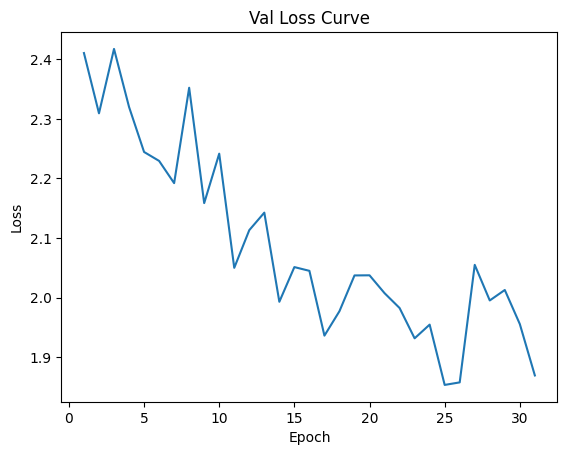

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [24]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.resnet34(weights=None).to(device)
    teacher_model.fc = nn.Linear(512, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


In [25]:
# Loop for training the student model with different lambda values
for i in lmda_list:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda0.pth'))
    teacher_model = teacher_model.to(device)
    
    # Reset the student model for each lambda
    student_model = torchvision.models.resnet18(weights=None).to(device)
    student_model.fc = nn.Linear(512, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=0, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    lambda_results[i].update({
        'student_mean_abs_val_disparity': student_mean_abs_val_disparity
    })


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:08<00:00,  4.16s/it]


*******Epoch 0: loss - 0.3896394794987094


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:08<00:00,  4.14s/it]


*******Epoch 1: loss - 0.33395586379112735


100%|██████████████████████████████████████████████████████████████████████████| 31/31 [02:09<00:00,  4.19s/it]


*******Epoch 2: loss - 0.31296479125176707


  0%|                                                                                   | 0/31 [00:30<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.19 GiB. GPU 0 has a total capacty of 14.75 GiB of which 825.06 MiB is free. Including non-PyTorch memory, this process has 13.94 GiB memory in use. Of the allocated memory 4.44 GiB is allocated by PyTorch, and 9.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [ ]:
# Loop through each lambda value
for lmda in lmda_list:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda}.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


In [ ]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Extracting disparity values for both teacher and student models
teacher_disparities = [lambda_results[lmda]['teacher_mean_abs_val_disparity'] for lmda in lambdas]
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_disparities, label='Teacher Average Disparity', marker='o')
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda}.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list)
